### Decision Tree Model Tuning for 2016 - 2020 Data (imports) with SMOTE

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import modelinghelper as helper

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from adspy_shared_utilities import plot_feature_importances
#from adspy_shared_utilities import plot_decision_tree

import joblib
import os
from datetime import datetime

# supress future warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [30]:
#set up random seed
rng = 42

# set up folder to save results
output_path = 'import_run8_SMOTEsampling_gridsearchCV'
dataset = 'import_SMOTE'

if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print("Folder already exists")

# file name
prefix = f'{output_path}/{dataset}'

Folder already exists


In [17]:
# read in data
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

In [18]:
df['ship_date_mm'] = df['ship_date_mm'].astype(str)

In [19]:
df.describe()

,control_number,qty,value,qty_new,ship_date_yyyy
count,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06
mean,2.018142e+09,1.955213e+06,9.658016e+03,1.954949e+06,2.017558e+03
std,1.263350e+06,2.644078e+08,9.355053e+05,2.644078e+08,1.279415e+00
min,2.014539e+09,-1.000000e+00,0.000000e+00,-1.000000e+00,2.016000e+03
25%,2.016978e+09,1.500000e+00,5.100000e+01,1.000000e+00,2.016000e+03
50%,2.017984e+09,9.000000e+00,3.180000e+02,8.000000e+00,2.017000e+03
75%,2.019505e+09,9.300000e+01,2.104000e+03,8.600000e+01,2.019000e+03
max,2.020755e+09,9.990708e+10,1.242236e+09,9.990708e+10,2.020000e+03


In [20]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'cartons', 'qty', 'unit', 'specific_generic_name',
                    'genus', 'species', 'wildlf_cat', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 'wildlf_cat',
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 
                 'value', 'ship_date_mm']

import_df= helper.df_filtering(df, i_e = 'I', f_cols = feature_cols)
# import: 1590505 rows × 12 columns
# export: 299340 rows × 12 columns

In [21]:
import_df.shape

(1590505, 12)

#### Modeling Pipeline

In [22]:
X_train, X_test, y_train, y_test = helper.data_split(import_df)

#### Decision Tree

In [23]:
# run 2 after updating SMOTE parameters
clf = DecisionTreeClassifier(random_state=rng)
dt_params={
    'clf__class_weight':[None,
                         'balanced', 
                         #{0:100, 1:1}, 
                         {0:50, 1:1}],
    'clf__max_depth': [2,3,4,5,6,7,8,9,10, None]
}

start = datetime.now()
dt_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, dt_params, imbalance_pipe=True) 
end = datetime.now()
print(f'model run time: {end - start}')

dt_pipe

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END clf__class_weight=None, clf__max_depth=2;, score=0.706 total time=  14.1s
[CV 2/5] END clf__class_weight=None, clf__max_depth=2;, score=0.669 total time=  13.6s
[CV 3/5] END clf__class_weight=None, clf__max_depth=2;, score=0.664 total time=  13.9s
[CV 4/5] END clf__class_weight=None, clf__max_depth=2;, score=0.667 total time=  13.5s
[CV 5/5] END clf__class_weight=None, clf__max_depth=2;, score=0.679 total time=  13.7s
[CV 1/5] END clf__class_weight=None, clf__max_depth=3;, score=0.793 total time=  14.8s
[CV 2/5] END clf__class_weight=None, clf__max_depth=3;, score=0.751 total time=  14.8s
[CV 3/5] END clf__class_weight=None, clf__max_depth=3;, score=0.754 total time=  14.8s
[CV 4/5] END clf__class_weight=None, clf__max_depth=3;, score=0.757 total time=  14.9s
[CV 5/5] END clf__class_weight=None, clf__max_depth=3;, score=0.765 total time=  14.9s
[CV 1/5] END clf__class_weight=None, clf__max_depth=4;, score=0.743 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('sampling',
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'clf__class_weight': [None, 'balanced', {0: 50, 1: 1}],
                         'clf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
             scoring='recall', verbose=3)

In [31]:
joblib.dump(dt_pipe, f'{prefix}_dt_pipe.joblib')

['import_run8_SMOTEsampling_gridsearchCV/import_SMOTE_dt_pipe.joblib']

#### Random Forest

In [25]:
clf = RandomForestClassifier(random_state=rng)
rf_params={
    'clf__n_estimators':[4, 10, 20, 30, 50, 100],
    'clf__max_depth': [None, 3, 5, 7, 9],
    'clf__class_weight':['balanced', None]
}

%time rf_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, rf_params, imbalance_pipe=True) 
rf_pipe

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.620 total time=  32.5s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.641 total time=  31.1s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.627 total time=  30.8s
[CV 4/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.629 total time=  32.9s
[CV 5/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.622 total time=  28.3s
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.644 total time=  49.2s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.664 total time=  48.9s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.654 total time=  48.5s
[CV 4/5] END cl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('sampling',
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__class_weight': ['balanced', None],
                         'clf__max_depth': [None, 3, 5, 7, 9],
                         'clf__n_estimators': [4, 10, 20, 30, 50, 100]},
             scoring='recall', verbose=3)

In [32]:
joblib.dump(rf_pipe, f'{prefix}_rf_pipe.joblib')

['import_run8_SMOTEsampling_gridsearchCV/import_SMOTE_rf_pipe.joblib']

Decision Tree (best model)
 [[  5083   1428]
 [ 58325 332791]]


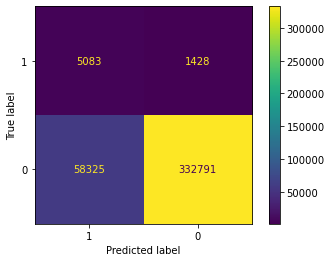

In [28]:
outputs = True
dt_predicted = dt_pipe.predict(X_test)
confusion = confusion_matrix(y_test, dt_predicted, labels = [1,0])
if outputs:
    print('Decision Tree (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()
    
    

Random Forest (best model)
 [[  5000   1511]
 [ 33001 358115]]


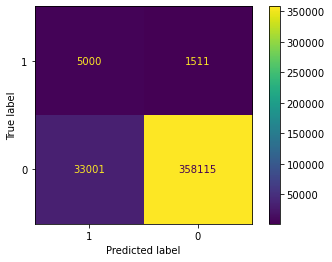

In [29]:
outputs = True
rf_predicted = rf_pipe.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted, labels = [1,0])
if outputs:
    print('Random Forest (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()